# Кластеризация вакансий по описанию и указанным скиллам
Смотрим данные
Собираем текст в одну кучку
    Убираем лишнее
    Токенизируем
Кластеризуем
Делаем выводы




In [3]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import string
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize


!ls

In [89]:
df = pd.read_excel('vacancies_2023-02-02-2023-02-03.xlsx')

In [8]:
# функция для токенизации и очистки текста

with open('stopwords-ru.txt', 'r') as f:
    russian_stop_words = [line.strip() for line in f]


def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove 'nan'
    text = text.replace('nan', '')
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove non-alphabetic characters from tokens
    tokens = [re.sub('[^a-zA-Zа-яА-Я]', '', token) for token in tokens]
    
    # Remove empty tokens
    tokens = [token for token in tokens if token]
    
    # Remove stop words from tokens
    stop_words = set(russian_stop_words)
    tokens = [token for token in tokens if token not in stop_words]
    
    # Convert tokens to lowercase
    tokens = [token.lower() for token in tokens]

    return tokens



In [90]:
# добавляем столбец с токенами
df['tokens'] = df[['key_skills_name','description',
       'key_skills_name_2', 'key_skills_name_3', 'key_skills_name_4',
       'key_skills_name_5', 
       'professional_roles_name', 'specializations_name',
       'key_skills_name_6', 'key_skills_name_7', 'key_skills_name_8',
       'key_skills_name_9', 'key_skills_name_10', 'salary',
       'key_skills_name_11', 'key_skills_name_12', 'key_skills_name_13',
       'key_skills_name_14', 'key_skills_name_15', 'key_skills_name_16',
       'key_skills_name_17', 'key_skills_name_18', 'key_skills_name_19',
       'key_skills_name_20', 'key_skills_name_21', 'key_skills_name_22',
       'key_skills_name_23', 'key_skills_name_24', 'key_skills_name_25',
       'key_skills_name_26', 'key_skills_name_27', 'key_skills_name_28',
       'key_skills_name_29', 'key_skills_name_30']].astype(str).apply(" ".join, axis=1).apply(preprocess_text)

In [21]:
# тренируем модель для последующего формирования эмбеддингов
sentences = df.tokens
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# сохраняем модель
model.save('w2v_model_old.bin')


In [23]:
# оставляю 3 колонки
df = df[['name','tokens_new','tokens']]
model = Word2Vec.load('w2v_model_old.bin')

# генерирую эмбеддинги
X = [np.mean([model.wv[token] for token in tokens if token in model.wv], axis=0) for tokens in df['tokens']]
X = StandardScaler().fit_transform(X)

# перебираю оптимальное количество кластеров используя silhouette score
sil_scores = []
for n_clusters in range(2, 15):
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X)
    labels = gmm.predict(X)
    sil_score = silhouette_score(X, labels)
    sil_scores.append(sil_score)
optimal_n_clusters = np.argmax(sil_scores) + 2

# GMM 
gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=42)
gmm.fit(X)

# пишу кластеры в колонку
df['cluster'] = gmm.predict(X)


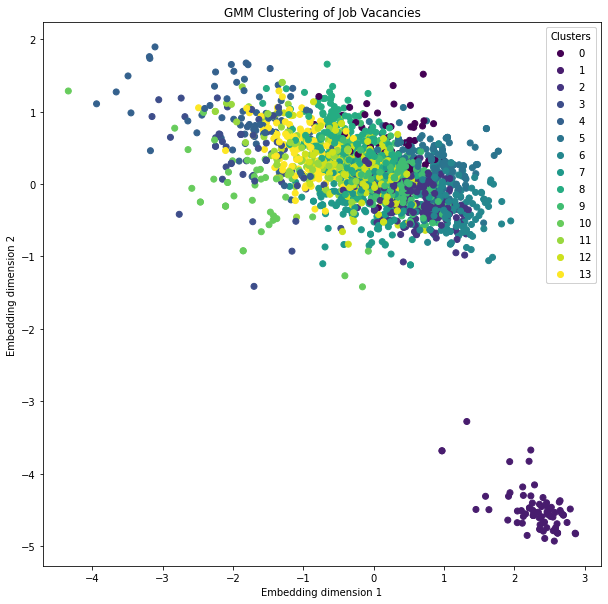

In [24]:
# визуализация кластеров в 2D
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(X[:,0], X[:,1], c=labels, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
ax.add_artist(legend1)
plt.xlabel('Embedding dimension 1')
plt.ylabel('Embedding dimension 2')
plt.title('GMM Clustering of Job Vacancies')
plt.show()

## Пробую идею с хабра, оставить токены в которых одно слово и токены из двух слов в которых первое слово русское, второе на латинице

In [91]:
def is_rus_eng(token):
    if len(token.split()) == 1:
        a = token
        if all(ord(c) < 128 for c in a):
            return True
        return False
    if len(token.split()) == 2:
        a, b = token.split()
        if all(ord(c) < 128 for c in b) and not all(ord(c) < 128 for c in a):
            return True
    return False


In [92]:
df['tokens_new'] = df['tokens'].apply(lambda x: [token for token in x if is_rus_eng(token)])

In [93]:
# тренируем модель для последующего формирования эмбеддингов
sentences = df.tokens_new
model = Word2Vec(sentences, vector_size=200, window=5, min_count=1, workers=4)

# сохраняем модель
model.save('w2v_model.bin')


In [84]:
# оставляю 3 колонки
df = df[['name','tokens_new','tokens']]
model = Word2Vec.load('w2v_model.bin')

# генерирую эмбеддинги
X = [np.mean([model.wv[token] for token in tokens if token in model.wv], axis=0) for tokens in df['tokens_new']]
X = StandardScaler().fit_transform(X)

# перебираю оптимальное количество кластеров используя silhouette score
sil_scores = []
for n_clusters in range(2, 15):
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X)
    labels = gmm.predict(X)
    sil_score = silhouette_score(X, labels)
    sil_scores.append(sil_score)
optimal_n_clusters = np.argmax(sil_scores) + 2

# GMM 
gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=42)
gmm.fit(X)

# пишу кластеры в колонку
df['cluster_1'] = gmm.predict(X)

X_2eng_rus = X

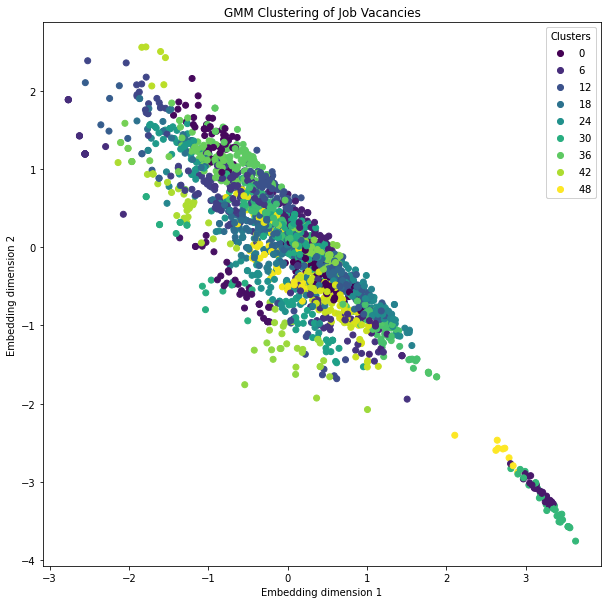

In [85]:
# визуализация кластеров в 2D
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(X_2eng_rus[:,0], X_2eng_rus[:,1], c=labels, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
ax.add_artist(legend1)
plt.xlabel('Embedding dimension 1')
plt.ylabel('Embedding dimension 2')
plt.title('GMM Clustering of Job Vacancies')
plt.show()

## Предыдущий вариант, только в эмбеддинги собираю максимальные значения

In [94]:
# оставляю 2 колонки
df = df[['name','tokens_new','tokens']]
model = Word2Vec.load('w2v_model.bin')

# генерирую эмбеддинги
X = [np.max([model.wv[token] for token in tokens if token in model.wv], axis=0) for tokens in df['tokens_new']]
X = StandardScaler().fit_transform(X)

# перебираю оптимальное количество кластеров используя silhouette score
sil_scores = []
for n_clusters in range(2, 15):
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X)
    labels = gmm.predict(X)
    sil_score = silhouette_score(X, labels)
    sil_scores.append(sil_score)
optimal_n_clusters = np.argmax(sil_scores) + 2

# GMM 
gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=42)
gmm.fit(X)

# пишу кластеры в колонку
df['cluster'] = gmm.predict(X)

X_max_emb = X

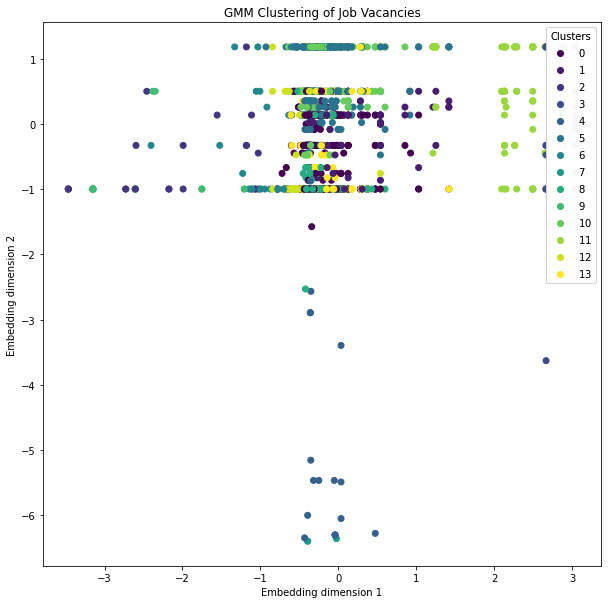

In [95]:
# визуализация кластеров в 2D
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(X_max_emb[:,0], X_max_emb[:,1], c=labels, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
ax.add_artist(legend1)
plt.xlabel('Embedding dimension 1')
plt.ylabel('Embedding dimension 2')
plt.title('GMM Clustering of Job Vacancies')
plt.show()

## Два предыдущих варианта вместе

In [96]:
# оставляю 2 колонки
df = df[['name','tokens_new','tokens']]

model = Word2Vec.load('w2v_model.bin')
model_old = Word2Vec.load('w2v_model_old.bin')

# генерирую эмбеддинги
X = []
for tokens in df['tokens']:
    # Get the word embeddings for each token
    embeddings = [model_old.wv[token] for token in tokens if token in model_old.wv]
    
    # Calculate the mean and max of the embeddings along the 0th axis
    mean_embedding = np.mean(embeddings, axis=0)
    X.append(mean_embedding)
    
X_1 = []    
for tokens in df['tokens_new']:
    # Get the word embeddings for each token
    embeddings = [model.wv[token] for token in tokens if token in model.wv]
    
    # Calculate the mean and max of the embeddings along the 0th axis   
    max_embedding = np.max(embeddings, axis=0)
    X_1.append(max_embedding)
    
    
    # Concatenate the two summary vectors
combined_embedding = np.concatenate([X,X_1], axis = 1)
    
    # Append the combined vector to the document embeddings list
X = combined_embedding

X = StandardScaler().fit_transform(X)


# перебираю оптимальное количество кластеров используя silhouette score
sil_scores = []
for n_clusters in range(2, 15):
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X)
    labels = gmm.predict(X)
    sil_score = silhouette_score(X, labels)
    sil_scores.append(sil_score)
optimal_n_clusters = np.argmax(sil_scores) + 2

# GMM 
gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=42)
gmm.fit(X)

# пишу кластеры в колонку
df['cluster'] = gmm.predict(X)

X_comb = X


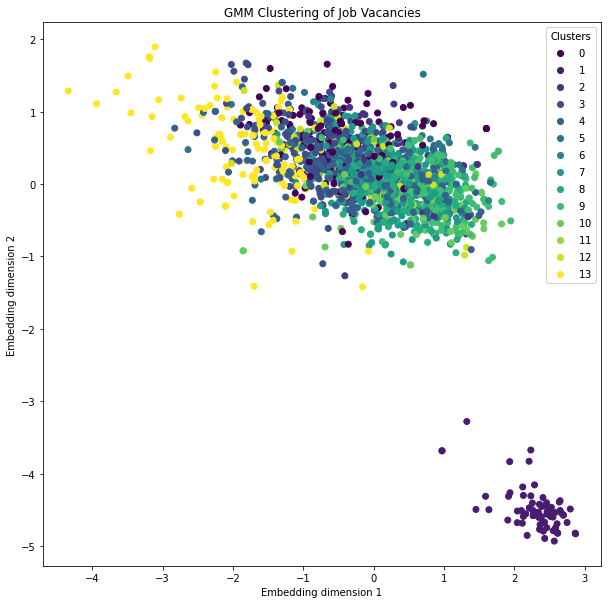

In [98]:
# визуализация кластеров в 2D
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(X_comb[:,0], X_comb[:,1], c=labels, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
ax.add_artist(legend1)
plt.xlabel('Embedding dimension 1')
plt.ylabel('Embedding dimension 2')
plt.title('GMM Clustering of Job Vacancies')
plt.show()

## Другая визуализация, располагающая кластеры из многомерного пространства на двумерном

C:\Users\VilGu\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\VilGu\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


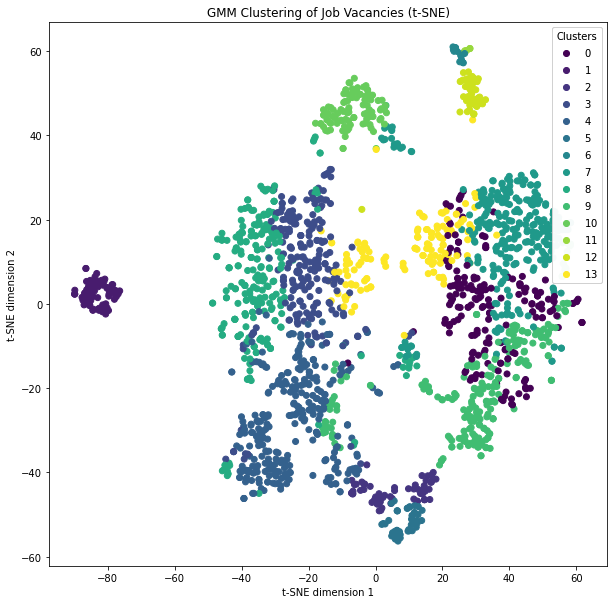

In [99]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Compute t-SNE embedding of X
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_comb)

# Plot the t-SNE embedding
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
ax.add_artist(legend1)
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.title('GMM Clustering of Job Vacancies (t-SNE)')
plt.show()


## Разбивка на кластеры и подсчет частоты слов в названии вакансии


In [102]:
gmm = GaussianMixture(n_components=15, random_state=42)
gmm.fit(X)
df['cluster'] = gmm.predict(X_comb)

In [106]:
n = 5 # какое количество слов показать

from collections import Counter

def most_common_words(text_list):
    words = []
    for text in text_list:
        for word in text.lower().split():
            if word not in russian_stop_words:
                words.append(word.strip('.,!?-'))

    # используем Counter для подсчета частоты слов
    word_counts = Counter(words)

    # находим n наиболее часто встречающихся слов
    top_words = word_counts.most_common(n)

    # возвращаем словарь с парами "слово: количество"
    return dict(top_words)

In [107]:
for i in range(df.cluster.nunique()):
    a = df.name[df.cluster == i].to_list()
    print(i, most_common_words(a))

0 {'разработчик': 35, 'инженер': 24, 'python': 23, 'программист': 20, 'developer': 19}
1 {'engineer': 30, 'senior': 20, 'developer': 14, 'devops': 13, 'lead': 10}
2 {'аналитик': 22, 'данных': 9, 'продуктовый': 7, 'аналитик-разработчик': 4, 'команду': 4}
3 {'python': 49, 'developer': 39, 'разработчик': 36, 'инженер': 30, 'программист': 28}
4 {'аналитик': 100, 'data': 48, 'данных': 43, 'analyst': 38, 'ведущий': 22}
5 {'разработчик': 6, 'специалист': 6, 'поддержки': 6, 'службы': 5, 'техническими': 5}
6 {'senior': 6, 'manager': 6, '/': 5, 'аналитик': 5, 'user': 3}
7 {'инженер': 65, 'devops': 51, 'engineer': 48, 'developer': 44, 'разработчик': 40}
8 {'engineer': 41, 'инженер': 39, 'разработчик': 25, 'data': 23, 'developer': 22}
9 {'преподаватель': 30, 'разработчик': 27, 'аналитик': 23, 'developer': 19, 'команду': 18}
10 {'engineer': 22, 'data': 12, 'senior': 11, 'qa': 10, 'инженер': 10}
11 {'автор': 2, 'работ': 2, 'программированию': 2, 'python': 2, 'инженер-программист': 1}
12 {'инженер': 

## Вывод: 
Кластеризовать по требованиям скиллов сложно. Всё склеивается в одну кучку. 
Одинаковые скиллы и технологии используются в разных профессиях.
Надо увеличить датасет. 
Для поиска самых частоупоминаемых скиллов можно пробовать без ML считать количество упоминаний технологии и навыка (собрать список ключевых слов и считать их в разрезе по профессиям)
